### Import Libraries

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import mlflow.pyfunc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score

from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

### Set display option to show Max Row & Column

In [76]:
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)

In [77]:
cleaned_df = pd.read_csv(r'C:\Users\ASUS PC\Desktop\AMDARI INTERNSHIP\Med_Optix\Optix_repo\Model\clened_df.csv')

In [78]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21898 entries, 0 to 21897
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    21898 non-null  object 
 1   hospital_id             21898 non-null  int64  
 2   ward_code               21898 non-null  object 
 3   wait_minutes            21898 non-null  float64
 4   length_of_stay_days     21898 non-null  float64
 5   age                     21898 non-null  float64
 6   procedure_flag          21898 non-null  int64  
 7   admission_count         21898 non-null  int64  
 8   arrival_ambulance       21898 non-null  int64  
 9   arrival_referral        21898 non-null  int64  
 10  arrival_self            21898 non-null  int64  
 11  arrival_transfer        21898 non-null  int64  
 12  triage_1.0              21898 non-null  float64
 13  triage_2.0              21898 non-null  float64
 14  triage_3.0              21898 non-null

In [79]:
def quick_overview(df, df_name):
  print(f"{df_name} dataframe information")
  print("="*60)
  print(df.info())
  print("\n")
  print(f"{df_name} missing values information")
  print("="*60)
  print(df.isnull().sum())
  print("\n")
  print(f"{df_name} describtion information")
  print("="*60)
  print(df.describe())
  print(f'Structure of {df_name} dataset')
  print('='*60)
  print(f"Row:{df.shape[0]}, Columns:{df.shape[1]}")

In [80]:
quick_overview(cleaned_df,'cleaned_df')

cleaned_df dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21898 entries, 0 to 21897
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    21898 non-null  object 
 1   hospital_id             21898 non-null  int64  
 2   ward_code               21898 non-null  object 
 3   wait_minutes            21898 non-null  float64
 4   length_of_stay_days     21898 non-null  float64
 5   age                     21898 non-null  float64
 6   procedure_flag          21898 non-null  int64  
 7   admission_count         21898 non-null  int64  
 8   arrival_ambulance       21898 non-null  int64  
 9   arrival_referral        21898 non-null  int64  
 10  arrival_self            21898 non-null  int64  
 11  arrival_transfer        21898 non-null  int64  
 12  triage_1.0              21898 non-null  float64
 13  triage_2.0              21898 non-null  float64
 14  triag

### Define target

In [81]:

target = 'admissions' 

In [82]:
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

In [83]:
cleaned_df['date'].dtype

dtype('<M8[ns]')

### Sort Data by date

In [84]:
cleaned_df = cleaned_df.sort_values('date').reset_index(drop=True)

### Create a 'month' feature from the date


In [85]:

cleaned_df['month'] = cleaned_df['date'].dt.to_period('M').dt.to_timestamp()

In [86]:
cleaned_df.head()

,date,hospital_id,ward_code,wait_minutes,length_of_stay_days,age,procedure_flag,admission_count,arrival_ambulance,arrival_referral,arrival_self,arrival_transfer,triage_1.0,triage_2.0,triage_3.0,triage_4.0,triage_5.0,outcome_death,outcome_discharged,outcome_readmit_30d,outcome_transferred,sex_F,sex_M,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate,hospital_name,city,country,latitude,longitude,founded_year,ward_id,ward_name,month,week,age_group
0,2022-10-28,1,ED,189.0,0.0,57.0,0,12,4,2,6,0,0.0,2.0,4.0,6.0,0.0,0,8,0,4,4,8,30,34,34,26,51,17,0.999,219,1.700,0.567,1.000,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department,2022-10-01,2022-10-24/2022-10-30,45-64
1,2022-10-28,5,SURG,151.0,4.0,52.0,5,8,4,0,4,0,-1.0,-1.0,-1.0,-1.0,-1.0,0,7,1,0,1,7,40,46,42,2,25,8,0.972,123,0.625,0.200,0.913,Kuopio Medical Center,Kuopio,Finland,61.6540,28.4874,2003,05-SURG,Surgery,2022-10-01,2022-10-24/2022-10-30,45-64
2,2022-10-28,5,MED,186.0,4.0,63.0,1,8,1,2,5,0,-1.0,-1.0,-1.0,-1.0,-1.0,0,7,1,0,3,5,50,58,54,4,34,7,0.972,167,0.680,0.140,0.931,Kuopio Medical Center,Kuopio,Finland,61.6540,28.4874,2003,05-MED,General Medicine,2022-10-01,2022-10-24/2022-10-30,45-64
3,2022-10-28,5,ICU,222.0,6.0,49.0,1,8,1,1,6,0,-1.0,-1.0,-1.0,-1.0,-1.0,2,6,0,0,3,5,20,23,23,3,12,2,1.016,167,0.600,0.100,1.000,Kuopio Medical Center,Kuopio,Finland,61.6540,28.4874,2003,05-ICU,Intensive Care Unit,2022-10-01,2022-10-24/2022-10-30,45-64
4,2022-10-28,5,ED,221.0,0.0,52.0,0,12,4,2,6,0,0.0,3.0,3.0,6.0,0.0,0,11,0,1,3,9,30,34,34,24,53,16,1.047,163,1.767,0.533,1.000,Kuopio Medical Center,Kuopio,Finland,61.6540,28.4874,2003,05-ED,Emergency Department,2022-10-01,2022-10-24/2022-10-30,45-64


### Sort by month to maintain correct time order


In [87]:

cleaned_df = cleaned_df.sort_values('month').reset_index(drop=True)

### Handle Missing Value in Triage_Level Column using group mode imputation


In [88]:
columns_to_convert = ['triage_1.0','triage_2.0','triage_3.0','triage_4.0','triage_5.0']


# We use a dictionary comprehension to apply pd.to_numeric to each column (Series)
# within the selected DataFrame slice and then assign the result back.
converted_columns = {
    col: pd.to_numeric(cleaned_df[col], errors='coerce') 
    for col in columns_to_convert
}

# Assign the resulting converted columns back to the DataFrame
cleaned_df[columns_to_convert] = pd.DataFrame(converted_columns)

# The rest of your code (imputation) remains correct
cleaned_df[columns_to_convert] = (
    cleaned_df.groupby('ward_code')[columns_to_convert]
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)) 
    .fillna(-1) 
)

In [89]:
cleaned_df.head()

,date,hospital_id,ward_code,wait_minutes,length_of_stay_days,age,procedure_flag,admission_count,arrival_ambulance,arrival_referral,arrival_self,arrival_transfer,triage_1.0,triage_2.0,triage_3.0,triage_4.0,triage_5.0,outcome_death,outcome_discharged,outcome_readmit_30d,outcome_transferred,sex_F,sex_M,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate,hospital_name,city,country,latitude,longitude,founded_year,ward_id,ward_name,month,week,age_group
0,2022-10-28,1,ED,189.0,0.0,57.0,0,12,4,2,6,0,0.0,2.0,4.0,6.0,0.0,0,8,0,4,4,8,30,34,34,26,51,17,0.999,219,1.70,0.567,1.000,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department,2022-10-01,2022-10-24/2022-10-30,45-64
1,2022-10-30,2,MED,158.0,5.0,63.0,1,8,1,1,5,1,-1.0,-1.0,-1.0,-1.0,-1.0,0,7,1,0,2,6,50,58,58,14,28,22,0.977,218,0.56,0.440,1.000,Tampere City Hospital,Tampere,Finland,63.2868,22.6592,2008,02-MED,General Medicine,2022-10-01,2022-10-24/2022-10-30,45-64
2,2022-10-30,2,ICU,151.0,5.0,54.0,0,8,2,0,5,1,-1.0,-1.0,-1.0,-1.0,-1.0,1,7,0,0,1,7,20,23,23,7,12,4,0.956,172,0.60,0.200,1.000,Tampere City Hospital,Tampere,Finland,63.2868,22.6592,2008,02-ICU,Intensive Care Unit,2022-10-01,2022-10-24/2022-10-30,45-64
3,2022-10-30,1,ED,207.0,0.0,52.0,1,12,3,1,8,0,0.0,5.0,0.0,3.0,4.0,0,10,0,2,8,4,30,34,34,39,63,28,0.953,275,2.10,0.933,1.000,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-ED,Emergency Department,2022-10-01,2022-10-24/2022-10-30,45-64
4,2022-10-30,1,SURG,101.0,2.0,43.0,3,8,5,1,2,0,-1.0,-1.0,-1.0,-1.0,-1.0,0,8,0,0,4,4,40,46,43,3,20,16,0.933,146,0.50,0.400,0.935,Helsinki Central Hospital,Helsinki,Finland,63.6698,25.0721,1979,01-SURG,Surgery,2022-10-01,2022-10-24/2022-10-30,18-44


In [90]:
cleaned_df.tail()

,date,hospital_id,ward_code,wait_minutes,length_of_stay_days,age,procedure_flag,admission_count,arrival_ambulance,arrival_referral,arrival_self,arrival_transfer,triage_1.0,triage_2.0,triage_3.0,triage_4.0,triage_5.0,outcome_death,outcome_discharged,outcome_readmit_30d,outcome_transferred,sex_F,sex_M,base_beds,effective_capacity,occupancy,overflow,admissions,discharges,staffing_index,avg_wait_minutes,admission_rate_per_bed,discharge_rate_per_bed,occupancy_rate,hospital_name,city,country,latitude,longitude,founded_year,ward_id,ward_name,month,week,age_group
21893,2025-10-09,5,ICU,225.0,6.0,59.0,0,8,2,2,4,0,-1.0,-1.0,-1.0,-1.0,-1.0,1,7,0,0,6,2,20,23,23,8,8,3,1.021,187,0.400,0.150,1.000,Kuopio Medical Center,Kuopio,Finland,61.6540,28.4874,2003,05-ICU,Intensive Care Unit,2025-10-01,2025-10-06/2025-10-12,45-64
21894,2025-10-09,5,ED,230.0,0.0,43.0,1,12,3,3,5,1,0.0,4.0,1.0,6.0,1.0,0,10,0,2,6,6,30,34,34,30,55,29,1.029,262,1.833,0.967,1.000,Kuopio Medical Center,Kuopio,Finland,61.6540,28.4874,2003,05-ED,Emergency Department,2025-10-01,2025-10-06/2025-10-12,18-44
21895,2025-10-09,3,SURG,174.0,3.0,56.0,6,8,4,1,3,0,-1.0,-1.0,-1.0,-1.0,-1.0,0,8,0,0,4,4,40,46,46,17,27,16,0.943,170,0.675,0.400,1.000,Turku University Hospital,Turku,Finland,64.6781,27.3280,1998,03-SURG,Surgery,2025-10-01,2025-10-06/2025-10-12,45-64
21896,2025-10-09,4,ICU,192.0,7.0,53.0,1,8,0,2,6,0,-1.0,-1.0,-1.0,-1.0,-1.0,0,8,0,0,7,1,20,23,23,5,9,6,1.038,170,0.450,0.300,1.000,Oulu Regional Hospital,Oulu,Finland,60.4406,25.1527,2003,04-ICU,Intensive Care Unit,2025-10-01,2025-10-06/2025-10-12,45-64
21897,2025-10-26,5,SURG,95.0,3.0,64.0,6,8,0,2,4,2,-1.0,-1.0,-1.0,-1.0,-1.0,0,8,0,0,2,6,40,40,39,0,20,15,0.877,81,0.500,0.375,0.975,Kuopio Medical Center,Kuopio,Finland,61.6540,28.4874,2003,05-SURG,Surgery,2025-10-01,2025-10-20/2025-10-26,45-64


### Separating Numeric and Categorical Columns

identifying and separating numeric and non-numeric (categorical) columns from `merged_df` for targeted analysis:

In [95]:
num_cols = cleaned_df.select_dtypes(include=[np.number]).columns.to_list()
cat_cols = cleaned_df.select_dtypes(exclude=[np.number]).columns.to_list()

### Remove target and date-related columns from features

In [96]:
num_cols = [col for col in num_cols if col not in ['admissions']]
cat_cols = [col for col in cat_cols if col not in ['date', 'month']]

### Define Numerical Transformation Pipeline

In [98]:
num_trans = Pipeline(steps= [
                     ('imputer',SimpleImputer(strategy='mean')),
                     ('rscaler', RobustScaler()),
                     ('scaler', StandardScaler())
                     ]
)

### Define Categorical Transformation Pipeline

In [99]:
cat_trans = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))


])

### Combine numerical and categorical pipelines into a single preprocessor


In [100]:
preprocessor = ColumnTransformer(transformers= [
    ('num',num_trans, num_cols),
    ('cat', cat_trans, cat_cols)


])

### Split Data by Date (Train/Val/Test)

In [101]:
train_size = 0.8
test_size = 0.2

# Sort again to be safe
cleaned_df = cleaned_df.sort_values('month')

train_size = int(len(cleaned_df) * 0.8)


train = cleaned_df.iloc[:train_size]

test = cleaned_df.iloc[train_size:]

### Define Target and Feature

In [102]:
target_col = 'admissions'

X_train = train.drop(columns=[target_col])
y_train = train[target_col]


X_test = test.drop(columns=[target_col])
y_test = test[target_col]

### Define Metric Function

In [103]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, rmse, mape

### RANDOM FOREST MODEL with MLflow

In [105]:
mlflow.set_experiment("Hospital_Admissions_Forecast")

with mlflow.start_run(run_name="RandomForestRegressor"):
    rf_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
    ])

    rf_model.fit(X_train, y_train)
    predt = rf_model.predict(X_test)

    
    mae = mean_absolute_error(y_test, predt)
    mse = mean_squared_error(y_test, predt)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, predt) * 100
    print(f"Prediction error (MAE): {mae:.2f}")
    print(f"Prediction error (MSE): {mse:.2f}")
    print(f"Prediction error (RMSE): {rmse:.2f}")
    print(f"Prediction error (MAPE): {mape:.1f}")

    mlflow.log_params({"n_estimators": 200, "random_state": 42})
    mlflow.log_metrics({"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape})
    mlflow.sklearn.log_model(
        sk_model=rf_model,
        name="RandomForestRegressor",
        input_example=X_test.iloc[:1]
    )

Prediction error (MAE): 0.01
Prediction error (MSE): 0.02
Prediction error (RMSE): 0.15
Prediction error (MAPE): 0.1


## Prophet Model (for Monthly Forecasting)

#### Prophet only needs the date (month) and target columns.

In [106]:
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'], errors='coerce')
cleaned_df['month'] = cleaned_df['date'].dt.to_period('M').dt.to_timestamp()

In [107]:
cleaned_df = cleaned_df.dropna(subset=['month'])

In [108]:
print(cleaned_df['month'].min(), cleaned_df['month'].max())

2022-10-01 00:00:00 2025-10-01 00:00:00


In [109]:
cleaned_df = cleaned_df[cleaned_df['month'].dt.year < 2100]

In [148]:


# Keep only the relevant columns
prophet_train = train[['month', target_col] ].rename(columns={'month': 'ds', target_col: 'y'})
prophet_test = test[['month', target_col] ].rename(columns={'month': 'ds', target_col: 'y'})

# Convert 'ds' to datetime and filter realistic years
prophet_train['ds'] = pd.to_datetime(prophet_train['ds'], errors='coerce')
prophet_test['ds'] = pd.to_datetime(prophet_test['ds'], errors='coerce')
prophet_train = prophet_train[prophet_train['ds'].dt.year < 2100]
#prophet_test = prophet_test[prophet_train['ds'].dt.year < 2100]
input_sample = prophet_train[['ds']].head(1)

with mlflow.start_run(run_name="Prophet") as prophet_run:
    prophet_model = Prophet(daily_seasonality=False, weekly_seasonality= False, yearly_seasonality=True)
   
    
        
    prophet_model.fit(prophet_train)

    forecast = prophet_model.predict(future)
    # Extract predictions for test period
    # Get the last N predictions (where N = length of test)
    test_predt = forecast[['ds','yhat']].tail(len(prophet_test))
    #predtt = forecast['yhat'].iloc[-len(test):].values
    #comparison = test.merge(test_predt, on='ds')
    

    
    mae = mean_absolute_error(prophet_test['y'],test_predt['yhat'])
    mse = mean_squared_error(prophet_test['y'],test_predt['yhat'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(prophet_test['y'],test_predt['yhat']) * 100
    print(f"Prediction error (MAE): {mae:.2f}")
    print(f"Prediction error (MSE): {mse:.2f}")
    print(f"Prediction error (RMSE): {rmse:.2f}")
    print(f"Prediction error (MAPE): {mape:.1f}")
    mlflow.log_params({"daily_seasonality": False, "weekly_seasonality": False, "yearly_seasonality":True })
    mlflow.log_metrics({"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape})
    mlflow.prophet.log_model(prophet_model, 
    name="ProphetModel",
    input_example=input_sample)

16:05:00 - cmdstanpy - INFO - Chain [1] start processing
16:05:03 - cmdstanpy - INFO - Chain [1] done processing


Prediction error (MAE): 15.58
Prediction error (MSE): 341.27
Prediction error (RMSE): 18.47
Prediction error (MAPE): 101.9


In [146]:

regressors = [
    #'wait_minutes', 'admission_count',
    'arrival_ambulance',
    'arrival_referral','arrival_self', 'arrival_transfer', 
     'triage_1.0', 'triage_2.0', 'triage_3.0',
    'triage_4.0','triage_5.0',#'outcome_discharged','overflow'
]
# Keep only the relevant columns
prophet_train = train[['month', target_col] + regressors].rename(columns={'month': 'ds', target_col: 'y'})
prophet_test = test[['month', target_col] + regressors].rename(columns={'month': 'ds', target_col: 'y'})

# Convert 'ds' to datetime and filter realistic years
prophet_train['ds'] = pd.to_datetime(prophet_train['ds'], errors='coerce')
prophet_test['ds'] = pd.to_datetime(prophet_test['ds'], errors='coerce')
prophet_train = prophet_train[prophet_train['ds'].dt.year < 2100]
#prophet_test = prophet_test[prophet_train['ds'].dt.year < 2100]
input_sample = prophet_train[['ds']].head(1)

with mlflow.start_run(run_name="Prophet") as prophet_run:
    prophet_model = Prophet(daily_seasonality=False, weekly_seasonality= False, yearly_seasonality=True)
   
    for r in regressors:
        prophet_model.add_regressor(r)
        
    prophet_model.fit(prophet_train)

    # Predict next len(test) months safely
    future = prophet_model.make_future_dataframe(periods=len(prophet_test))

    regressor_data = pd.concat([
    prophet_train[['ds'] + regressors],
    prophet_test[['ds'] + regressors]], ignore_index=True)

    future = future.merge(
    regressor_data,
    on='ds',
    how='left')
    



    # Loop through all regressors to fill any remaining NaNs (other than the now-filled 'hospital_id')
    for r in regressors:
        if r != 'hospital_id' and future[r].isnull().any():
            # For other numeric regressors, use 0 as a placeholder for the forecast period
            future[r] = future[r].fillna(0)

    forecast = prophet_model.predict(future)
    # Extract predictions for test period
    # Get the last N predictions (where N = length of test)
    test_predt = forecast[['ds','yhat']].tail(len(prophet_test))
    #predtt = forecast['yhat'].iloc[-len(test):].values
    #comparison = test.merge(test_predt, on='ds')
    

    
    mae = mean_absolute_error(prophet_test['y'],test_predt['yhat'])
    mse = mean_squared_error(prophet_test['y'],test_predt['yhat'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(prophet_test['y'],test_predt['yhat']) * 100
    print(f"Prediction error (MAE): {mae:.2f}")
    print(f"Prediction error (MSE): {mse:.2f}")
    print(f"Prediction error (RMSE): {rmse:.2f}")
    print(f"Prediction error (MAPE): {mape:.1f}")
    mlflow.log_params({"daily_seasonality": False, "weekly_seasonality": False, "yearly_seasonality":True })
    mlflow.log_metrics({"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape})
    mlflow.prophet.log_model(prophet_model, 
    name="ProphetModel",
    input_example=input_sample)


16:02:56 - cmdstanpy - INFO - Chain [1] start processing
16:02:59 - cmdstanpy - INFO - Chain [1] done processing
2025/11/24 16:03:04 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: ValueError("Regressor 'arrival_ambulance' missing from dataframe"). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.


Prediction error (MAE): 49.45
Prediction error (MSE): 2819.13
Prediction error (RMSE): 53.10
Prediction error (MAPE): 214.7


2025/11/24 16:03:04 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "d.... Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: Regressor 'arrival_ambulance' missing from dataframe


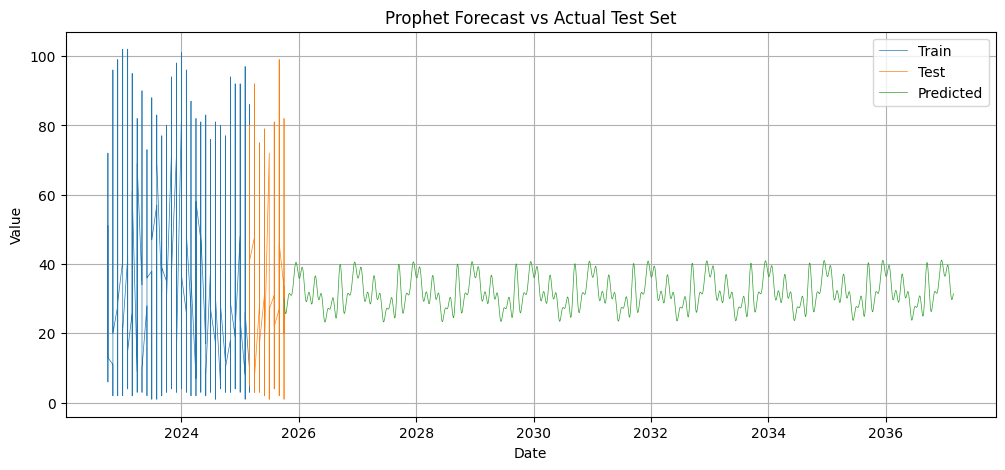

In [149]:
plt.figure(figsize=(12,5))
plt.plot(prophet_train['ds'], prophet_train['y'], label = 'Train', linewidth = 0.5)
plt.plot(prophet_test['ds'], prophet_test['y'], label = 'Test', linewidth = 0.5)
plt.plot(test_predt['ds'], test_predt['yhat'], label = 'Predicted', linewidth = 0.5)
plt.legend()
plt.title("Prophet Forecast vs Actual Test Set")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [113]:
test_predt['ds'].dtype

dtype('<M8[ns]')

In [114]:
prophet_test['ds'].dtype

dtype('<M8[ns]')

In [150]:
print(prophet_test)

              ds   y
17110 2025-03-01  57
17111 2025-03-01  56
17112 2025-03-01  24
17113 2025-03-01  53
17106 2025-03-01  19
17250 2025-03-01  49
17135 2025-03-01  73
17137 2025-03-01  26
17158 2025-03-01  52
17159 2025-03-01  26
17160 2025-03-01  34
17161 2025-03-01  15
17162 2025-03-01  66
17163 2025-03-01  12
17164 2025-03-01  27
17165 2025-03-01   8
17166 2025-03-01   8
17167 2025-03-01  51
17168 2025-03-01   7
17169 2025-03-01  27
17170 2025-03-01  22
17171 2025-03-01  19
17172 2025-03-01  22
17157 2025-03-01  55
17156 2025-03-01  24
17155 2025-03-01  11
17154 2025-03-01  36
17138 2025-03-01   8
17139 2025-03-01  46
17140 2025-03-01  10
17141 2025-03-01  25
17142 2025-03-01  19
17143 2025-03-01  61
17144 2025-03-01   9
17136 2025-03-01  18
17145 2025-03-01  37
17147 2025-03-01  67
17148 2025-03-01  23
17149 2025-03-01  41
17150 2025-03-01  37
17151 2025-03-01  14
17152 2025-03-01  63
17153 2025-03-01  24
17146 2025-03-01  15
17251 2025-03-01  38
17102 2025-03-01  76
17253 2025-03

In [153]:
print(round(test_predt,0))

              ds  yhat
21891 2025-10-01  30.0
21892 2025-10-01  30.0
21893 2025-10-01  30.0
21894 2025-10-01  30.0
21895 2025-10-01  30.0
21896 2025-10-01  30.0
21897 2025-10-01  30.0
21898 2025-10-01  30.0
21899 2025-10-01  30.0
21900 2025-10-01  30.0
21901 2025-10-01  30.0
21902 2025-10-01  30.0
21903 2025-10-01  30.0
21904 2025-10-01  30.0
21905 2025-10-01  30.0
21906 2025-10-01  30.0
21907 2025-10-01  30.0
21908 2025-10-01  30.0
21909 2025-10-01  30.0
21910 2025-10-01  30.0
21911 2025-10-01  30.0
21912 2025-10-01  30.0
21913 2025-10-01  30.0
21914 2025-10-01  30.0
21915 2025-10-01  30.0
21916 2025-10-01  30.0
21917 2025-10-01  30.0
21918 2025-10-01  30.0
21919 2025-10-01  30.0
21920 2025-10-01  30.0
21921 2025-10-01  30.0
21922 2025-10-01  30.0
21923 2025-10-01  30.0
21924 2025-10-01  30.0
21925 2025-10-01  30.0
21926 2025-10-01  30.0
21927 2025-10-01  30.0
21928 2025-10-01  30.0
21929 2025-10-01  30.0
21930 2025-10-01  30.0
21931 2025-10-01  30.0
21932 2025-10-01  30.0
21933 2025-

## SARIMAX Model (for Seasonal Patterns)

In [ ]:
with mlflow.start_run(run_name="SARIMAX"):
    sarimax_model = SARIMAX(train['admissions'],
                            order=(1,1,1),
                            seasonal_order=(1,1,1,12),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    
    sarimax_result = sarimax_model.fit(disp=False)
    pred = sarimax_result.forecast(steps=len(test))

    y_test = test['admissions']

    mae = mean_absolute_error(y_test, pred)
    print(f"Prediction error (MAE): {mae:.2f}")
    mse = mean_squared_error(y_test, pred)
    print(f"Prediction error (MSE): {mse:.2f}")
    rmse = np.sqrt(mse)
    print(f"Prediction error (RMSE): {rmse:.2f}")
    mape = np.mean(np.abs((y_test - pred) / y_test)) * 100
    print(f"Prediction error (MAPE): {mape:.2f}")

    mlflow.log_params({"order": (1,1,1), "seasonal_order": (1,1,1,12)})
    mlflow.log_metrics({"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape})
    mlflow.statsmodels.log_model(sarimax_result, "SARIMAXModel")

: 